In [543]:
import pathlib

import gym
import torch

from matplotlib import pyplot as plt

In [544]:
VIDEO_RECORD_DIR = pathlib.Path("../videos/reinforce/cartpole")

In [552]:
env = gym.make('CartPole-v1', new_step_api=True)

In [553]:
class reinforce(torch.nn.Module):

    def __init__(self, policy: torch.nn.Module) -> None:
        super().__init__()
        self.policy = policy
    
    def forward(self, state):
        return self.policy(state)

class ActionReplayBuffer(torch.nn.Module):

    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma

        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

    def __len__(self):
        return len(self.state_buffer)
    
    def push(self, state, action, reward):
        state = torch.FloatTensor(state).unsqueeze(dim=0)

        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
    
    def sample(self):
        self.reward_buffer.reverse()

        for i in range(len(self.reward_buffer) - 1):
            self.reward_buffer[i + 1] = self.reward_buffer[i + 1] + ((self.gamma) * self.reward_buffer[i])

        self.reward_buffer.reverse()

        state_tensor = torch.cat(self.state_buffer)
        action_tensor = torch.tensor(self.action_buffer)
        reward_tensor = torch.FloatTensor(self.reward_buffer)

        return state_tensor, action_tensor, reward_tensor

    def empty(self):
        self.__init__(self.gamma)

def categorical_policy(action_probabilities):
    output = torch.distributions.Categorical(action_probabilities)
    return output.sample().item()

def reinforce_loss(prob_batch, expected_returns_batch):
    error = torch.log(prob_batch) * expected_returns_batch
    return -torch.sum(error)


In [554]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n

HIDDEN_SIZE = 128

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

In [555]:
MAX_EPISODE_STEPS = 500
MAX_EPISODES = 5000
GOAL_SCORE = 450

learning_rate = 0.001
gamma = 0.99

In [556]:
agent = reinforce(model)
replay_buffer = ActionReplayBuffer(gamma)

optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [557]:
def torch_reinforce_train():
    score = []

    for trajectory in range(MAX_EPISODES + 1):
        state = env.reset()
        done = False
    
        for t in range(MAX_EPISODE_STEPS):
            torch_state = torch.from_numpy(state).float()
            action_probs = agent(torch_state)

            action = categorical_policy(action_probs)

            prev_state = state

            step_state = env.step(action)
            state, reward, done = step_state[0], step_state[1], step_state[2]

            replay_buffer.push(prev_state, action, reward)

            if done:
                break

        score.append(len(replay_buffer))

        state_batch, action_batch, reward_batch = replay_buffer.sample()
        replay_buffer.empty()

        reward_batch = reward_batch / torch.abs(reward_batch).max()
        # reward_batch = (reward_batch - reward_batch.mean()) / (reward_batch.std() + 1e-12)

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()
    
        optimizer.zero_grad()
        loss = reinforce_loss(prob_batch, reward_batch)
    
        loss.backward()
        optimizer.step()

        if trajectory % 100 == 0 and trajectory > 0:
            mean_score = sum(score[-100:-1]) / len(score[-100:-1])
            print('Trajectory {}\tAverage Score: {:.2f}\tLoss: {:.2f}'.format(trajectory, mean_score, loss.item()))

            if mean_score > GOAL_SCORE:
                break
    
    return score    

In [558]:
score = torch_reinforce_train()

Trajectory 100	Average Score: 33.53	Loss: 76.13
Trajectory 200	Average Score: 52.48	Loss: 86.99
Trajectory 300	Average Score: 63.54	Loss: 414.85
Trajectory 400	Average Score: 90.90	Loss: 553.24
Trajectory 500	Average Score: 205.08	Loss: 463.81
Trajectory 600	Average Score: 183.99	Loss: 224.89
Trajectory 700	Average Score: 181.84	Loss: 228.91
Trajectory 800	Average Score: 247.65	Loss: 261.48
Trajectory 900	Average Score: 285.86	Loss: 1478.35
Trajectory 1000	Average Score: 372.92	Loss: 1810.15
Trajectory 1100	Average Score: 365.05	Loss: 1028.52
Trajectory 1200	Average Score: 432.66	Loss: 2444.36
Trajectory 1300	Average Score: 456.33	Loss: 2444.25


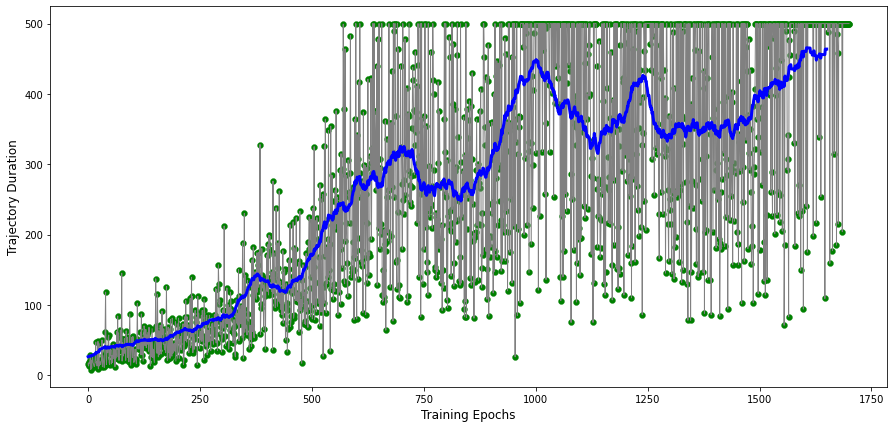

In [538]:
def running_mean(x):
    N=50
    kernel = torch.ones(N)
    conv_len = x.shape[0]-N
    y = torch.zeros(conv_len)
    for i in range(conv_len):
        y[i] = torch.matmul(kernel, x[i:i+N].float())
        y[i] /= N
    return y

score = torch.tensor(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))

plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)

plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)

plt.scatter(torch.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)

In [539]:
from gym.wrappers import RecordVideo

def watch_agent(max_steps=500):
    env = gym.make('CartPole-v1', new_step_api=True)
    env = RecordVideo(env, video_folder=VIDEO_RECORD_DIR)
    state = env.reset()

    rewards = []

    for t in range(max_steps):
        pred = model(torch.from_numpy(state).float())
        action = torch.argmax(pred).item()

        step_state = env.step(action)
        state, reward, done = step_state[0], step_state[1], step_state[2]

        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break

    env.close()

In [540]:
watch_agent()

/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /Users/lulu/Worskpace/rl-journey/videos/reinforce/cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/

Reward: 500.0
